In [1]:
from keras.applications import DenseNet201
# from keras.applications import InceptionV3
# from keras.applications import VGG16

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
DenseNet201 = DenseNet201(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in DenseNet201.layers:
    layer.trainable = False
    
# Let's print our layers 
# for (i,layer) in enumerate(MobileNet.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [2]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set our class number to 4
num_classes = 2

FC_Head = lw(DenseNet201, num_classes)

model = Model(inputs = DenseNet201.input, outputs = FC_Head)

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'dataset/train_face/'
validation_data_dir = 'dataset/val_face/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 4
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [5]:
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("face_recognition.h5",
                             monitor="val_loss",
                             save_best_only = True,
                             verbose=1,
                             mode = 'auto',
                             save_freq = 'epoch')

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 7,
                          verbose = 1,
                          mode = 'auto')

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]
# callbacks = [checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# model.compile(loss = 'categorical_crossentropy',
#               optimizer = SGD(lr=0.01),
#               metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 2000
nb_validation_samples = 400

# We only train 5 EPOCHS 
epochs = 10
batch_size = 4

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
#     steps_per_epoch = 11,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
#     validation_steps=2
)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.7895
Epoch 00001: val_loss improved from inf to 0.26925, saving model to face_recognition.h5
500/500 [==============================] - 552s 1s/step - loss: 0.4692 - accuracy: 0.7895 - val_loss: 0.2692 - val_accuracy: 0.8950
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8610
Epoch 00002: val_loss did not improve from 0.26925
500/500 [==============================] - 449s 897ms/step - loss: 0.3443 - accuracy: 0.8610 - val_loss: 0.2905 - val_accuracy: 0.8725
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.3251 - accuracy: 0.8660
Epoch 00003: val_loss did not improve from 0.26925
500/500 [==============================] - 435s 870ms/step - loss: 0.3251 - accuracy: 0.8660 - val_loss: 0.3695 - val_accuracy: 0.8625
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8805
Epoch 00004: val_loss im

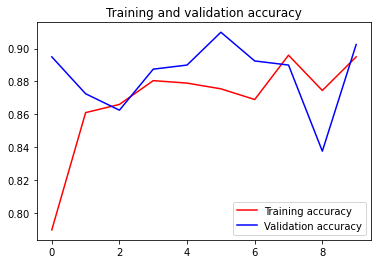

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

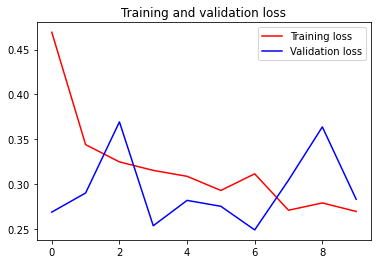

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np


probas = model.predict_generator(generator=validation_generator)
y_true = validation_generator.classes
y_pred = np.argmax(probas, axis=1)

print(y_true.shape)
print(y_pred.shape)


print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Instructions for updating:
Please use Model.predict, which supports generators.
(400,)
(400,)
[[116  84]
 [105  95]]
              precision    recall  f1-score   support

           0       0.52      0.58      0.55       200
           1       0.53      0.47      0.50       200

    accuracy                           0.53       400
   macro avg       0.53      0.53      0.53       400
weighted avg       0.53      0.53      0.53       400

